In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [2]:
!nvidia-smi

Sun Apr 21 06:22:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   35C    P8     7W / 198W |      2MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils.utils import get_train, convert
from utils.preprocess import preprocess_sentence, max_length, tokenize
from models.encoder import Encoder
from models.decoder import Decoder
from models.bahdanauattention import BahdanauAttention


import re
import numpy as np
import os
import io
import time

In [4]:
tf.__version__

'2.0.0-alpha0'

In [5]:
%%time
num_examples = 1000000
num_examples = 500000
df = get_train()
df_train = df[:num_examples].copy()
df_train['firstSentence'] = np.vectorize(preprocess_sentence)(df_train['firstSentence'])
df_train['secondSentence'] = np.vectorize(preprocess_sentence)(df_train['secondSentence'])
df_train.head(10)

CPU times: user 1min 40s, sys: 2.42 s, total: 1min 42s
Wall time: 1min 40s


In [6]:
%%time
input_tensor, inp_tokenizer = tokenize(df_train['firstSentence'].values.tolist())
target_tensor, targ_tokenizer = tokenize(df_train['secondSentence'].values.tolist())
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

CPU times: user 14.1 s, sys: 52 ms, total: 14.1 s
Wall time: 14 s


In [7]:
convert(inp_tokenizer, input_tensor_train[5])
convert(targ_tokenizer, target_tensor_train[4])

1	<start>
7	i
26	don
4	'
14	t
137	believe
44	in
13	that
3	.
2	<end>
1	<start>
7	i
359	knew
5	you
88	would
3	.
2	<end>


In [8]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_tokenizer.word_index)+1
vocab_tar_size = len(targ_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 51]), TensorShape([64, 49]))

In [9]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [10]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_tokenizer.word_index['<start>']] *
                                   BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden,
                                                 enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [11]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [12]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Encoder output shape: (batch size, sequence length, units) (64, 51, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)
Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 51, 1)
Decoder output shape: (batch_size, vocab size) (64, 20101)


In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [14]:
EPOCHS = 10
for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.3333
Epoch 1 Batch 100 Loss 0.5399
Epoch 1 Batch 200 Loss 0.5789
Epoch 1 Batch 300 Loss 0.4672
Epoch 1 Batch 400 Loss 0.4240
Epoch 1 Batch 500 Loss 0.3996
Epoch 1 Batch 600 Loss 0.3728
Epoch 1 Batch 700 Loss 0.3415
Epoch 1 Batch 800 Loss 0.3694
Epoch 1 Batch 900 Loss 0.3326
Epoch 1 Batch 1000 Loss 0.3275
Epoch 1 Batch 1100 Loss 0.3062
Epoch 1 Batch 1200 Loss 0.3451
Epoch 1 Batch 1300 Loss 0.2661
Epoch 1 Batch 1400 Loss 0.2446
Epoch 1 Batch 1500 Loss 0.2659
Epoch 1 Batch 1600 Loss 0.2793
Epoch 1 Batch 1700 Loss 0.1989
Epoch 1 Batch 1800 Loss 0.2424
Epoch 1 Batch 1900 Loss 0.2191
Epoch 1 Batch 2000 Loss 0.1959
Epoch 1 Batch 2100 Loss 0.2263
Epoch 1 Batch 2200 Loss 0.2051
Epoch 1 Batch 2300 Loss 0.1979
Epoch 1 Batch 2400 Loss 0.1890
Epoch 1 Batch 2500 Loss 0.2489
Epoch 1 Batch 2600 Loss 0.2277
Epoch 1 Batch 2700 Loss 0.2684
Epoch 1 Batch 2800 Loss 0.1979
Epoch 1 Batch 2900 Loss 0.1755
Epoch 1 Batch 3000 Loss 0.1928
Epoch 1 Batch 3100 Loss 0.2159
Epoch 1 Batch 3200 L

In [15]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_tokenizer.index_word[predicted_id] + ' '

        if targ_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [16]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [17]:
def re_parapharse(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted re_parapharse: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [18]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [19]:
df.tail(10)

,firstSentence,secondSentence
40653986,I think it 's a great idea .,"Oh , no ."
40653987,I feel fine .,Not bad .
40653988,He might be dead .,Right .
40653989,Finished .,I don 't get it .
40653990,"All right , thank you .",Keep moving .
40653991,I beg of you .,Now ?
40653992,Go .,sobbing
40653993,Everything 's fine .,What 's this about ?
40653994,I did .,RIGHT .
40653995,Amazing .,"Oh , my ."


Input: <start> right . <end>
Predicted re_parapharse: right . <end> 


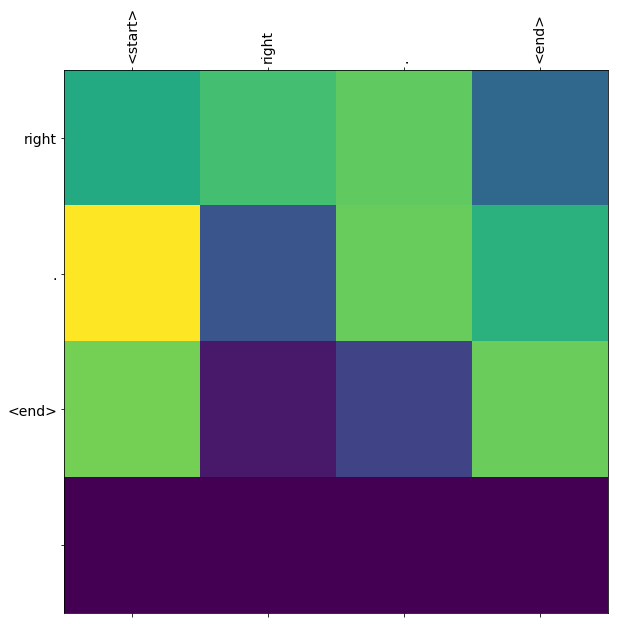

Input: <start> right . <end>
Predicted re_parapharse: right . <end> 


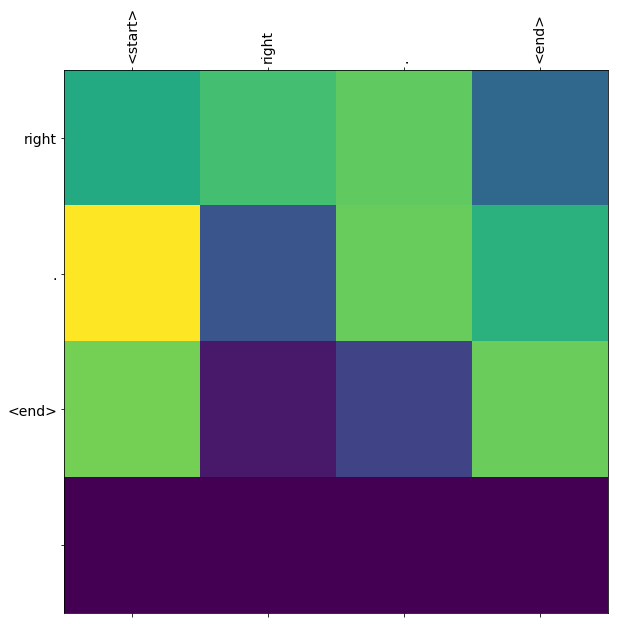

Input: <start> right . <end>
Predicted re_parapharse: right . <end> 


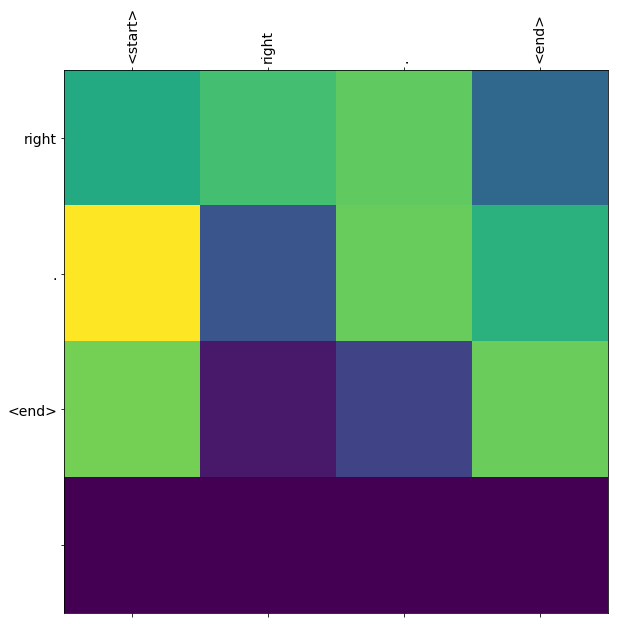

Input: <start> okay , i ' m out of here . <end>
Predicted re_parapharse: right , i ' m out of here . <end> 


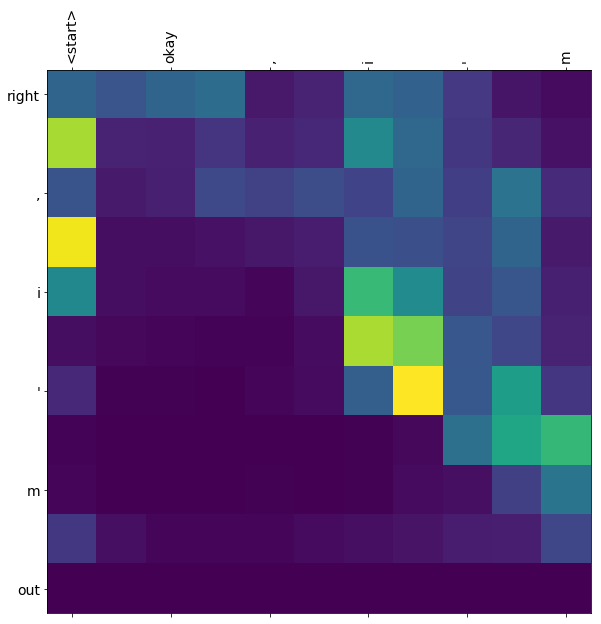

Input: <start> oh man . <end>
Predicted re_parapharse: oh shit . <end> 


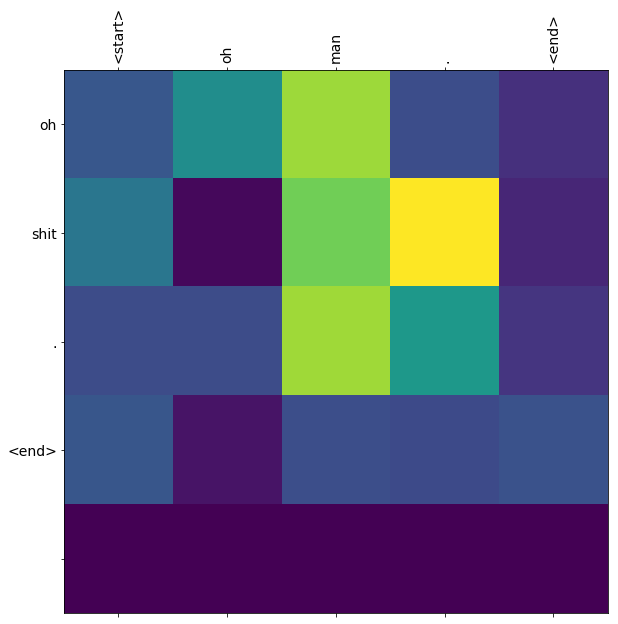

Input: <start> not a clue . <end>
Predicted re_parapharse: l ' m not a clue . <end> 


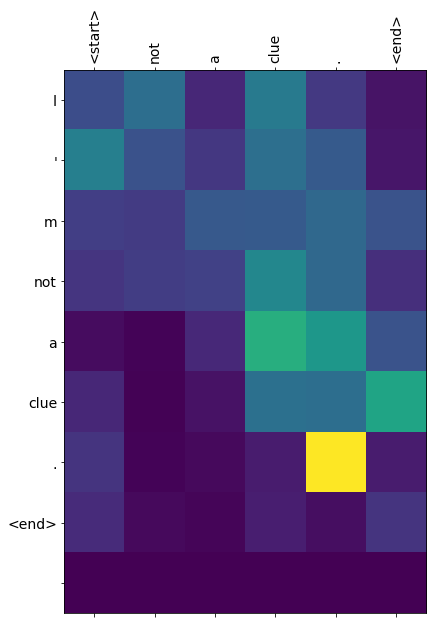

Input: <start> move . <end>
Predicted re_parapharse: move it . <end> 


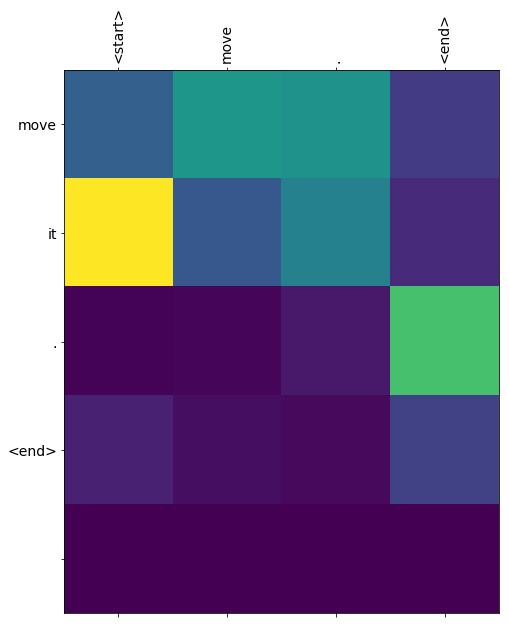

Input: <start> keep it down . <end>
Predicted re_parapharse: keep it down . <end> 


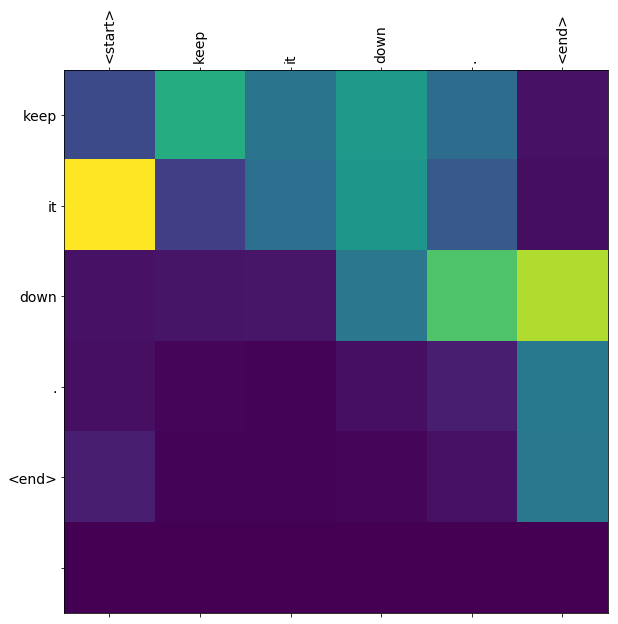

Input: <start> i won ' t let them . <end>
Predicted re_parapharse: i won ' t permit it . <end> 


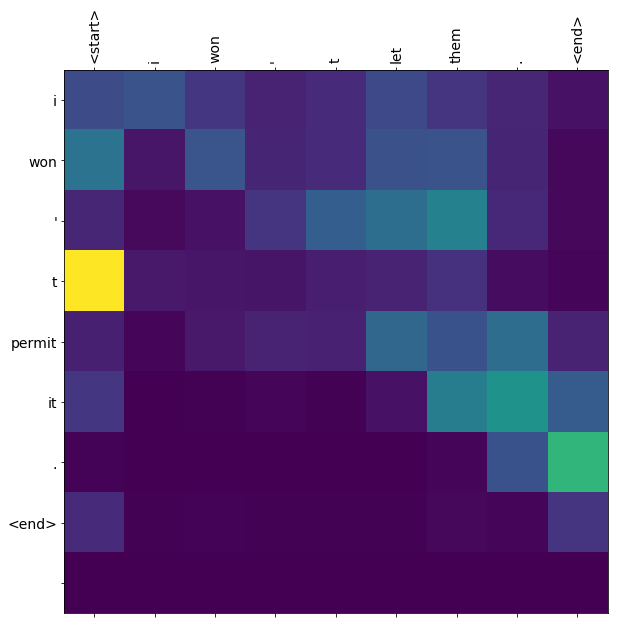

Input: <start> i will . <end>
Predicted re_parapharse: i will . <end> 


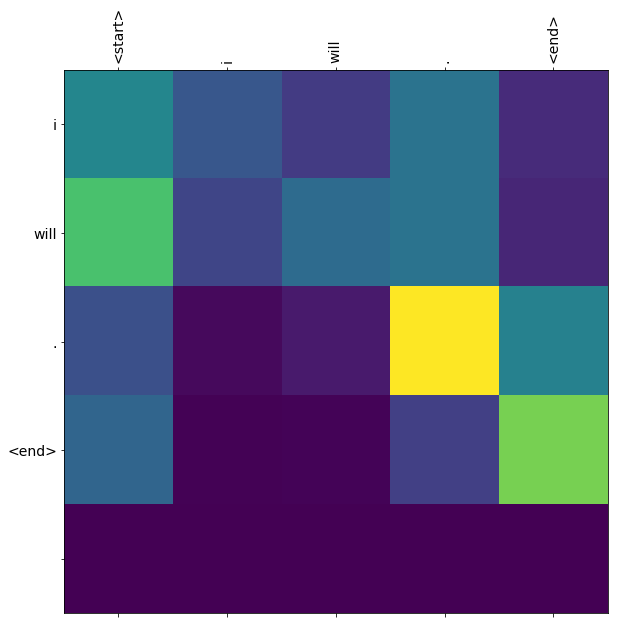

Input: <start> i think it ' s a great idea . <end>
Predicted re_parapharse: i think it ' s a great idea . <end> 


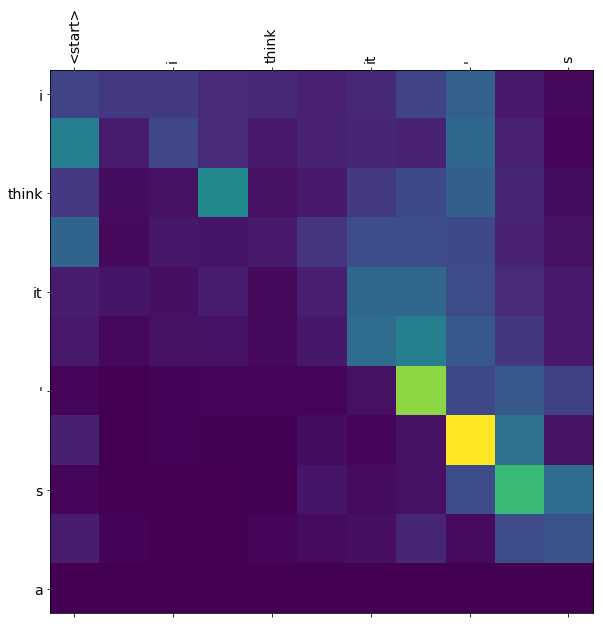

Input: <start> i feel fine . <end>
Predicted re_parapharse: i feel fine . <end> 


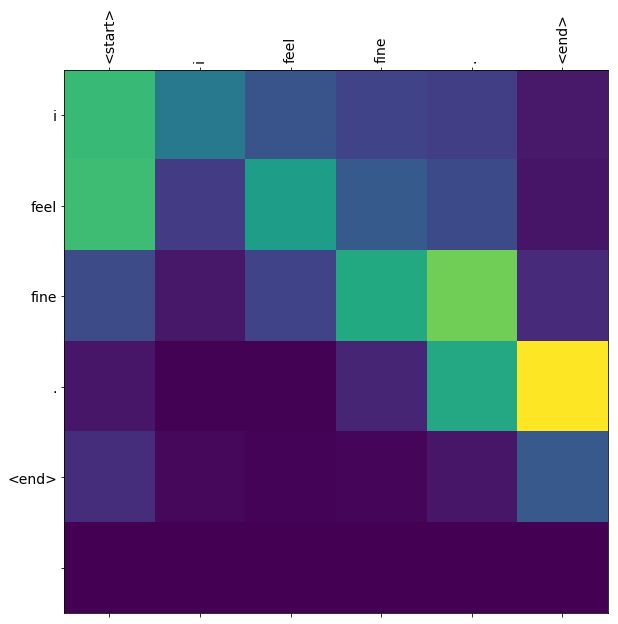

Input: <start> he might be dead . <end>
Predicted re_parapharse: he might be dead . <end> 


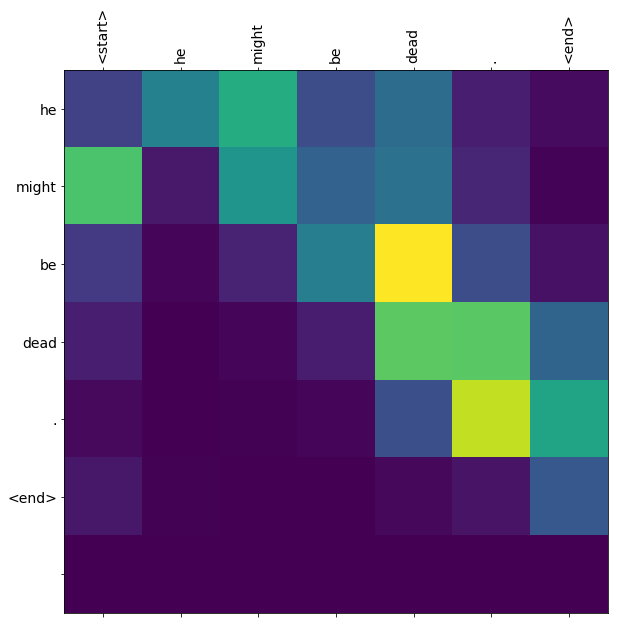

Input: <start> finished . <end>
Predicted re_parapharse: it ' s over . <end> 


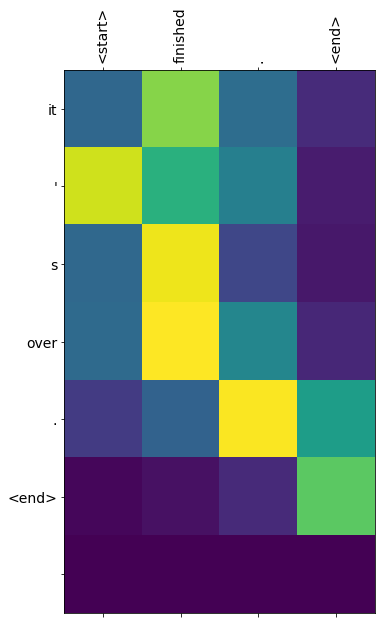

Input: <start> all right , thank you . <end>
Predicted re_parapharse: okay , thanks . <end> 


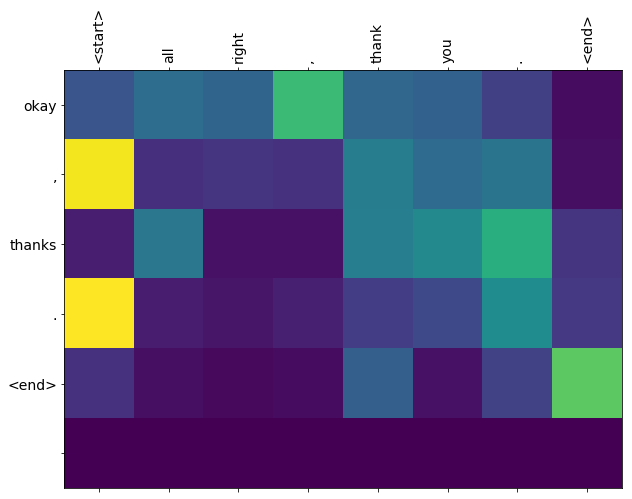

Input: <start> i beg of you . <end>
Predicted re_parapharse: i beg you . <end> 


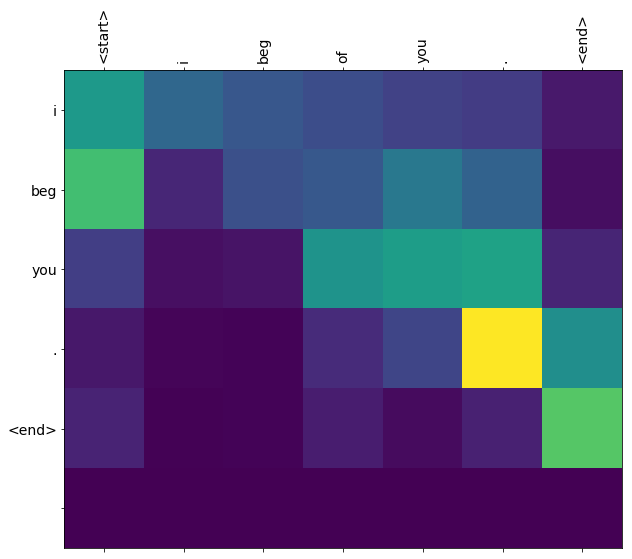

Input: <start> go . <end>
Predicted re_parapharse: go on , let ' s go away . <end> 


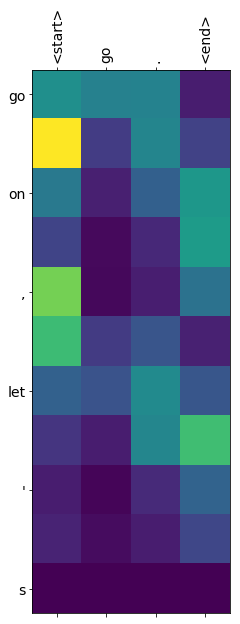

Input: <start> everything ' s fine . <end>
Predicted re_parapharse: everything is fine . <end> 


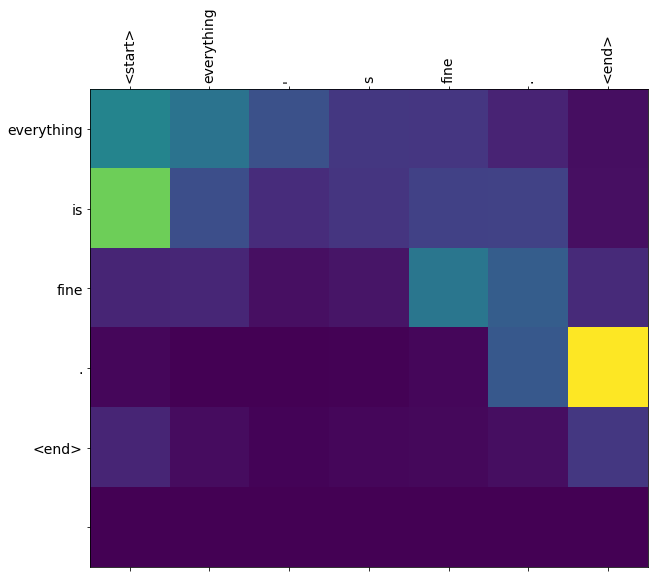

Input: <start> i did . <end>
Predicted re_parapharse: i did . <end> 


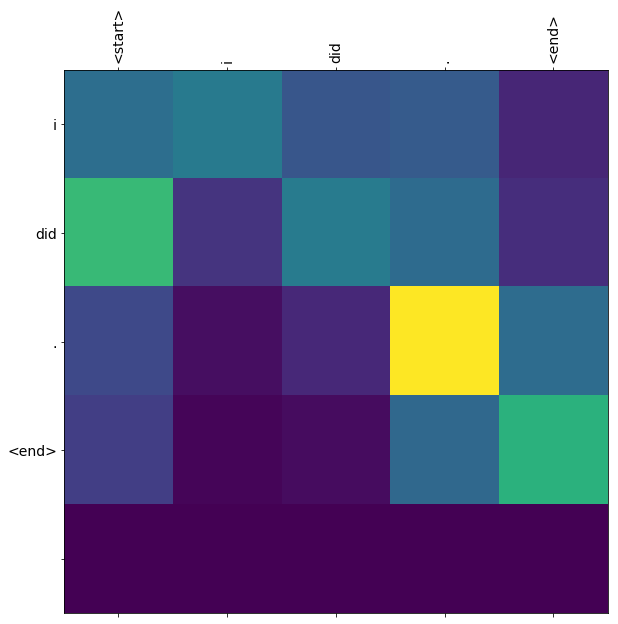

Input: <start> amazing . <end>
Predicted re_parapharse: that ' s amazing . <end> 


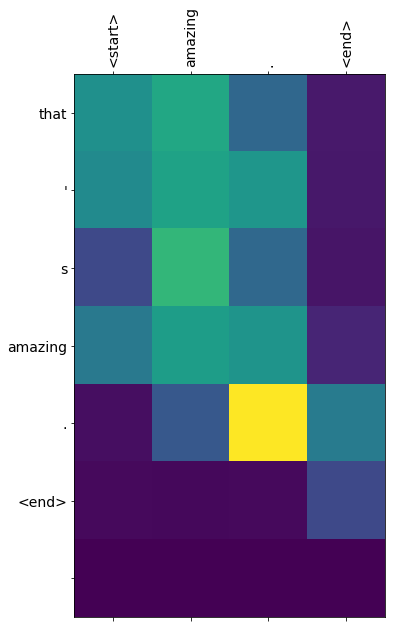

In [21]:
for x in df.iloc[-20:, :].firstSentence.values:
    re_parapharse(x)